In [3]:
import numpy as np
import pandas as pd

from pathlib import Path

In [4]:
data_dir = Path("./plmdata/raw")

alsfrs_fn = data_dir/"user_ALSFRS_score.csv"
condition_fn = data_dir/"user_condition.csv"
onset_fn = data_dir/"user_onset_date.csv"
symptom_fn = data_dir/"user_symptom.csv"

als = "amyotrophic lateral sclerosis"

In [5]:
alsfrs = pd.read_csv(alsfrs_fn, index_col=0)
alsfrs["report_date"] = pd.to_datetime(alsfrs["report_date"])

condition = pd.read_csv(condition_fn, index_col=0)
onset = pd.read_csv(onset_fn, index_col=0)

onset["first_definitive_diagnosis_date"] = pd.to_datetime(onset["first_definitive_diagnosis_date"])

symptom = pd.read_csv(symptom_fn, index_col=0)

In [6]:
print(alsfrs.columns)
print(condition.columns)
print(onset.columns)
print(symptom.columns)

Index(['user_id', 'report_date', 'score'], dtype='object')
Index(['user_id', 'condition_name'], dtype='object')
Index(['user_id', 'first_definitive_diagnosis_date'], dtype='object')
Index(['user_id', 'symptom_name', 'symptom_severity_score'], dtype='object')


In [7]:
print("Rows by table:")
print(f"  alsfrs:{len(alsfrs)}")
print(f"  condition:{len(condition)}")
print(f"  onset:{len(onset)}")
print(f"  symptom:{len(symptom)}")

Rows by table:
  alsfrs:4409
  condition:626914
  onset:229
  symptom:261716


# Check first few rows by table

In [8]:
# alsfrs.head()

In [9]:
# condition.head()

In [10]:
# onset.head()

In [11]:
# symptom.head()

# Check counts of rows by user_id

In [12]:
alsfrs_users = alsfrs.user_id.unique()

len(alsfrs_users)

200

In [13]:
condition_users = condition.user_id.unique()

In [14]:
len(condition_users)

435861

In [15]:
onset_users = onset.user_id.unique()

len(onset_users)

229

In [16]:
symptom_users = symptom.user_id.unique()

len(symptom_users)

35912

In [17]:
# Of 200 user_ids in alsfrs table, how many are in onset?

print(f"Number of alsfrs users (total {len(alsfrs_users)}) in onset: {np.sum(np.isin(onset_users, alsfrs_users))}")
print(f"Number of alsfrs users (total {len(alsfrs_users)}) in condition: {np.sum(np.isin(condition_users, alsfrs_users))}")
print(f"Number of alsfrs users (total {len(alsfrs_users)}) in symptom: {np.sum(np.isin(symptom_users, alsfrs_users))}")
print(f"Number of onset users (total {len(onset_users)}) in condition: {np.sum(np.isin(condition_users, onset_users))}")
print(f"Number of onset users (total {len(onset_users)}) in symptom: {np.sum(np.isin(symptom_users, onset_users))}")
print(f"Number of condition users (total {len(condition_users)}) in symptom (total {len(symptom_users)}): {np.sum(np.isin(symptom_users, condition_users))}")

Number of alsfrs users (total 200) in onset: 179
Number of alsfrs users (total 200) in condition: 197
Number of alsfrs users (total 200) in symptom: 16
Number of onset users (total 229) in condition: 225
Number of onset users (total 229) in symptom: 18
Number of condition users (total 435861) in symptom (total 35912): 32732


# What conditions do users in the alsfrs table have?

In [21]:
condition_als = condition[np.isin(condition.user_id, alsfrs.user_id)]

condition_als

,user_id,condition_name
2159,2520,hypothyroidism
3393,1229,diabetes type 2
4721,5283,generalized anxiety disorder
4722,5283,major depressive disorder
4723,5283,panic disorder
...,...,...
625049,3624,osteoarthritis
625050,3624,post-traumatic stress disorder
625051,3624,rheumatoid arthritis
625052,3624,systemic lupus erythematosus


In [22]:
condition_als.to_csv("./plmdata/raw/user_condition_alsfrs.csv", index=False)

In [23]:
conditions_all_alsfrs = condition_als.join(pd.get_dummies(condition_als["condition_name"])).drop("condition_name", axis=1).groupby("user_id").sum()

In [24]:
conditions_all_alsfrs.sum()

Parkinson's disease                                    6
amyotrophic lateral sclerosis                          2
bipolar disorder                                      18
diabetes type 2                                       12
epilepsy                                               7
fibromyalgia                                          58
generalized anxiety disorder                          20
high blood pressure (hypertension)                     8
high cholesterol (hypercholesterolemia)                4
hypothyroidism                                         7
major depressive disorder                             39
migraine                                               7
multiple sclerosis                                    29
myalgic encephalomyelitis/chronic fatigue syndrome    11
osteoarthritis                                         7
panic disorder                                        10
persistent depressive disorder (dysthymia)             9
post-traumatic stress disorder 

In [25]:
# Making sure everything reconciles

conditions_all_alsfrs.sum().sum()

298

Of the 200 users with data in alsfrs, only 197 are present in the conditions table and 179 are present in the onset date table. 

Those 197 users with entries in condition have 298 total conditions (rows in the condition table) among them. Oddly, only 2 of them are indicated as having ALS.

# Plotting example score series

In [26]:
import seaborn as sns

In [85]:
def get_user_score_series(user_id):
    return alsfrs[alsfrs.user_id == user_id].sort_values("report_date")
    

def get_user_onset_date(user_id):
    return onset[onset.user_id == user_id].first_definitive_diagnosis_date.item()

def get_user_plot(user_id):
    user_series = get_user_score_series(user_id)
    onset_date = get_user_onset_date(user_id)

    plot = user_series.plot.scatter("report_date", "score")
    plot.tick_params(axis='x', labelrotation=45)
    plot.set_ylim((0,50))
    plot.axvline(onset_date,linewidth=2, color='r')

    return plot

def get_jointplot(df, plot_type="kde"):
    sns.jointplot(
        x="offset_date", y="score",
        data=df, kind=plot_type
    )

def get_jointplot_random_sample(n_users, alsfrs_df, plot_type="kde"):
    use_plot_type = "kde"

    if plot_type == "scatter":
        use_plot_type = "scatter"

    selected_users = np.random.permutation(
        alsfrs_df.user_id
    )[:n_users]

    get_jointplot(
        alsfrs_df[np.isin(alsfrs_df.user_id,selected_users)], use_plot_type
    )

In [86]:
len(alsfrs_users[:100000])

200

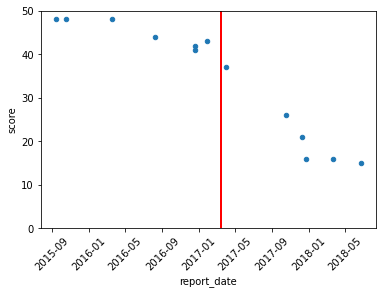

In [87]:
get_user_plot(6373)

In [88]:
alsfrs_sorted = alsfrs.sort_values(["user_id", "report_date"])

In [89]:
alsfrs_sorted["report_date"] = alsfrs_sorted.report_date.apply(lambda x: x.toordinal())

In [90]:
min_by_user = alsfrs_sorted.groupby("user_id")["report_date"].min().rename("first_date")

In [91]:
alsfrs_first=alsfrs_sorted.merge(min_by_user, left_on="user_id", right_index=True)

In [92]:
alsfrs_first["offset_date"] = alsfrs_first.report_date - alsfrs_first.first_date

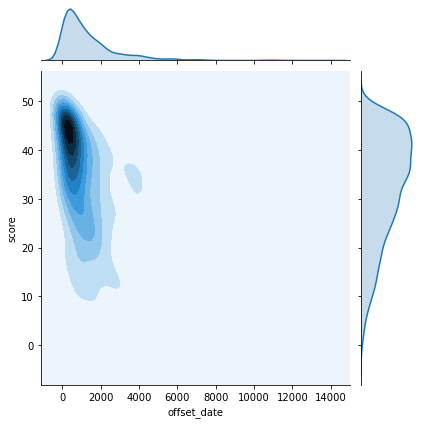

In [93]:
sns.jointplot(x="offset_date", y="score", data=alsfrs_first, kind="kde");

In [94]:
alsfrs_first

,user_id,report_date,score,first_date,offset_date
497,43,729975,45,729975,0
496,43,730079,36,729975,104
494,43,730133,29,729975,158
492,43,730259,24,729975,284
503,43,730504,20,729975,529
...,...,...,...,...,...
3693,7483,736886,33,732628,4258
3707,7483,736978,30,732628,4350
3702,7483,737213,31,732628,4585
3696,7483,737319,30,732628,4691


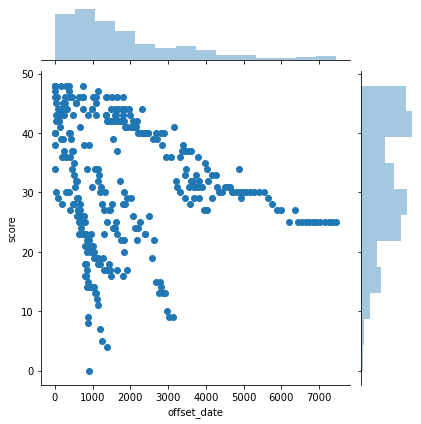

In [96]:
get_jointplot_random_sample(10, alsfrs_first, "scatter")